# A Bayesian Test for Cointegration

## Python notebook implementation

The code in this notebook is adapted from the original MATLAB implementation by Chris Bracegirdle for the paper [*Bayesian Conditional Cointegration*](http://icml.cc/2012/papers/570.pdf) presented at [*ICML 2012*](http://icml.cc/2012/).

In [1]:
from random import random, normalvariate
from numpy import sum, empty, polyfit, inf, array, isinf, where, nan, isnan, isreal
from scipy import log, sqrt, exp, std, pi
from scipy.misc import logsumexp
from scipy.stats import norm 

""" Bayesian Cointegration 
Implementation of a Bayesian test for cointegration

Written by Chris Bracegirdle
(c) Chris Bracegirdle 2015. All rights reserved."""

' Bayesian Cointegration \nImplementation of a Bayesian test for cointegration\n\nWritten by Chris Bracegirdle\n(c) Chris Bracegirdle 2015. All rights reserved.'

Some notebook-specific requirements here: we're going to show some plots, so let's show them inline. And for debugging, never swallow an overflow with just a warning, please numpy!

In [2]:
import matplotlib.pyplot as plt
from numpy import seterr
seterr(over='raise')
%matplotlib inline

This is a rather contrived function to randomly generate two time series, `x` and `y`, after making a random decision as to whether they are cointegrated, and generating according to the corresponding generating function

In [3]:
def GenerateData(T):
    cointegrated = random() > 0.5
    phi = random() * 2 - 1 if cointegrated else 1

    std_eta = exp(normalvariate(0,1))
    std_x = exp(normalvariate(0,1))
    intercept = normalvariate(0,5)
    slope = normalvariate(1,5)
    #print "Intercept", intercept
    #print "Slope", slope
    
    epsilon = empty([T])
    x = empty([T])
    y = empty([T])
    epsilon[0] = normalvariate(0,std_eta)
    x[0] = normalvariate(0,std_x)
    y[0] = intercept + slope * x[0] + epsilon[0]
    for t in range(1,T):
        epsilon[t] = phi * epsilon[t-1] + normalvariate(0, std_eta)
        x[t] = x[t-1] + normalvariate(0 ,std_x)
        y[t] = intercept + slope * x[t] + epsilon[t]
    return cointegrated,x,y

And here's what some randomly-generated data look like. Give it a whirl!

Cointegrated? False


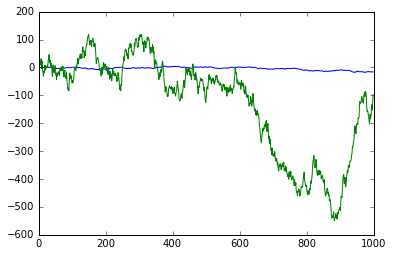

In [4]:
cointegrated,x,y = GenerateData(1000)
plt.plot(x)
plt.plot(y)
print "Cointegrated?",cointegrated

In [5]:
def LinearRegression(x,y):
    slope, intercept = polyfit(x, y, 1)
    std_eta = std( y - intercept - slope * x , ddof=1 )
    return slope, intercept, std_eta

In [6]:
LinearRegression(x,y)

(19.6297413653121, -48.422956376420203, 142.98613260755775)

This is a key result from the paper: calculating the moments and area as derived in the paper

In [7]:
def CalcLogAreaLog(logf,logF):
    lncdf = norm.logcdf([1,-1], loc=exp(logf).real, scale=exp(0.5*logF).real)
    logarea = logsumexp([lncdf[0], lncdf[1]],b=[1, -1])-log(2)
    return logarea

def CalcMomentsLog(logf,logF,logarea):
    lnpdf = norm.logpdf([1,-1], loc=exp(logf).real, scale=exp(0.5*logF).real)
    logmoment1 = logsumexp([lnpdf[0]+logF-logarea, lnpdf[1]+logF-logarea, logf],b=[-0.5, 0.5, 1])
    logmoment2 = logsumexp([logF+logf+lnpdf[0]-logarea, logF+logf+lnpdf[1]-logarea, 
                            logF+lnpdf[0]-logarea, logF+lnpdf[1]-logarea, 2*logf, logF],
                           b=[-0.5, 0.5, 
                            -0.5, -0.5, 1, 1])
    return exp(logmoment1).real, exp(logmoment2).real

Now inference: filtering and the EM update routine.

In [8]:
def Filtering(V,std_eta):
    T = V.size
        
    # DIRECT METHOD
    logft = log(sum(V[1:]*V[:T-1]))-log(sum(V[:T-1]**2))
    logFt = 2*log(std_eta) - log(sum(V[:T-1]**2))
    assert isreal(logFt), "logFt must be real"
    logarea = CalcLogAreaLog(logft,logFt)
    loglik = -0.5*log(sum(V[:T-1]**2))-0.5*(T-2)*log(2*pi*std_eta**2)+logarea  \
                        -(sum(V[1:]**2)-sum(V[1:]*V[:T-1])**2/sum(V[:T-1]**2))/(2*std_eta**2)

    # calculate moments
    moment1,moment2 = CalcMomentsLog(logft,logFt,logarea)
    
    return loglik,moment1,moment2

def EMUpdate(x,y,moment1,moment2):
    T = x.size
    xt, xtm1 = x[1:], x[:T-1]
    yt, ytm1 = y[1:], y[:T-1]
    
    # find the coefficients
    a = 2 * (T-1) * moment1 - (T-1) * moment2 - (T-1)
    b = moment1 * sum(xt+xtm1) - moment2 * sum(xtm1) - sum(xt)
    c = moment2 * sum(ytm1) - moment1 * sum(yt + ytm1) + sum(yt)
    d = 2 * moment1 * sum(xt * xtm1) - moment2 * sum(xtm1 ** 2) - sum(xt ** 2)
    e = moment2 * sum(xtm1 * ytm1) - moment1 * sum(xtm1 * yt + xt * ytm1) + sum(xt * yt)
        
    # solve simultaneous equations
    slope = ((a * e) - (c * b)) / ((b ** 2) - (a * d))
    intercept = (-slope * d / b) - (e / b)

    # now find optimal sigma
    eps = y - intercept - slope * x
    ept, eptm1 = eps[1:], eps[:T-1]
    std_eta = sqrt( (sum(ept**2) - 2 * moment1 * sum( ept * eptm1)  + moment2 * sum(eptm1 ** 2)) / (T-1) )

    assert std_eta>0,"Standard deviation must be positive"
    assert isreal(std_eta),"Standard deviation must be real"
    return slope,intercept,std_eta

This is the real meat of the routine, simple since the inference routines are given above.

In [9]:
def CointInference(epsilon,std_eta,x,y):
    loglik,moment1,moment2 = Filtering(epsilon,std_eta)
    slope,intercept,std_eta = EMUpdate(x,y,moment1,moment2)
    #std_eta_with_old_regression = sqrt( (sum(epsilon[1:]**2) \
    #                                      - 2 * sum(moment1 * epsilon[1:] * epsilon[:-1]) \
    #                                      + sum(moment2 * epsilon[:-1] ** 2)) / (x.size - 1) )
    return loglik,slope,intercept,std_eta#,std_eta_with_old_regression,moment1

And finally, the function we'll expose to check for cointegration using the Bayesian method.

In [10]:
def BayesianLearningTest(x,y):

    slope, intercept, std_eta_coint = LinearRegression(x,y)

    # cointegrated case - learn slope, intercept, std by ML
    logliks = [-inf]
    for i in range(1000):
        assert ~isnan(intercept), "Intercept cannot be nan"
        assert ~isnan(slope), "Slope cannot be nan"
        assert isreal(std_eta_coint), "Standard deviation must be real"
        assert std_eta_coint > 0, "Standard deviation must be greater then 0"

        loglik_coint,slope,intercept,std_eta_coint = CointInference(y-intercept-slope*x,std_eta_coint,x,y)
        
        if loglik_coint-logliks[-1]<0.00001: break
        logliks = logliks + [loglik_coint]
    
    # non-cointegrated case - use above slope, intercept, use ML std
    epsilon = y-intercept-slope*x
    std_eta_p1 = sqrt(((epsilon[1:]-epsilon[:-1])**2).mean())
    loglik_p1 = sum(norm.logpdf(epsilon[1:], loc=epsilon[:-1], scale=std_eta_p1))

    bayes_factor = exp(loglik_p1 - loglik_coint)
    cointegrated = loglik_coint > loglik_p1
    
    #print "slope,intercept", slope,intercept
    return loglik_p1 - loglik_coint#cointegrated

## Bringing it all together
Here we'll test the routine. First, generate some data to use.

Cointegrated? False


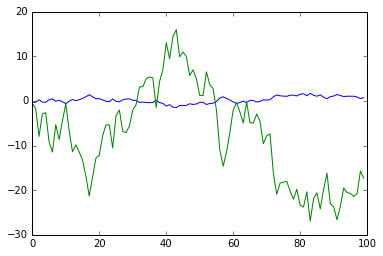

In [11]:
cointegrated,x,y = GenerateData(100)
plt.plot(x)
plt.plot(y)
print "Cointegrated?",cointegrated

And let's try the Bayesian routine to see if the result matches the truth given above when generating

In [12]:
BF = BayesianLearningTest(x,y)
test_result = BF<0
print "Test result:", test_result
if test_result == cointegrated:
    print "Congratulations! The result of the routine matches the ground truth"
else:
    print "Unfortunately the routine disagreed with the ground truth"

Test result: False
Congratulations! The result of the routine matches the ground truth


## Comparing with Dickey-Fuller

For comparison purposes we now test for cointegration using the standard test.

In [13]:
from statsmodels.tsa.stattools import adfuller
slope,intercept,_=LinearRegression(x,y);
epsilon=y-intercept-slope*x;
adf=adfuller(epsilon, maxlag=1, autolag=None, regression="ct");
pvalue = adf[1]
cointegrated_adf = pvalue<0.05
cointegrated_adf

False

## ROC curve: Bayesian test versus Dickey Fuller

Both the Bayesian learning test and the Dickey-Fuller test do the job and provide a test statistic which we compare against a threshold. To compare which test is better, we look at the ROC curve, and in particular, the AUC of the ROC. To do that, we repeatedly generate time series and perform both tests, then plot the resulting ROC curve.

In [14]:
from numpy import zeros, mod
T=20
experiments = 5000

cointegratedActual=zeros(experiments, dtype=bool)
logBF=zeros(experiments)
pvalue=zeros(experiments)
    
for expr in range(0,experiments):
    cointegratedActual[expr],x,y=GenerateData(T);

    #classical test
    slope,intercept,_=LinearRegression(x,y);
    epsilon=y-intercept-slope*x;
    adf=adfuller(epsilon, maxlag=1, autolag=None, regression="ct");
    pvalue[expr]=adf[1]

    #bayesian test
    logBF[expr]=BayesianLearningTest(x,y)
    if mod(expr+1,experiments/20)==0:
        print "Experiment",expr+1,"of",experiments

Experiment 250 of 5000
Experiment 500 of 5000
Experiment 750 of 5000
Experiment 1000 of 5000
Experiment 1250 of 5000
Experiment 1500 of 5000
Experiment 1750 of 5000
Experiment 2000 of 5000
Experiment 2250 of 5000
Experiment 2500 of 5000
Experiment 2750 of 5000
Experiment 3000 of 5000
Experiment 3250 of 5000
Experiment 3500 of 5000
Experiment 3750 of 5000
Experiment 4000 of 5000
Experiment 4250 of 5000
Experiment 4500 of 5000
Experiment 4750 of 5000
Experiment 5000 of 5000


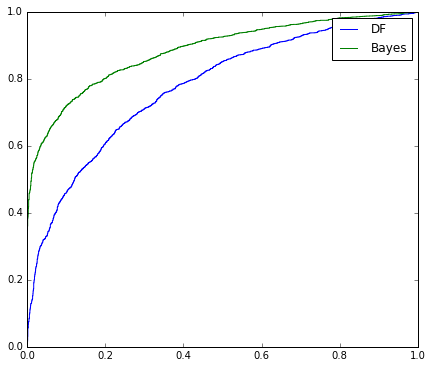

roc_auc_DF 0.777434408799
roc_auc_Bayes 0.884706972838


In [15]:
from sklearn.metrics import roc_curve, auc
fpr_DF, tpr_DF, _ = roc_curve(cointegratedActual*1.0, -pvalue)
roc_auc_DF = auc(fpr_DF, tpr_DF)
fpr_Bayes, tpr_Bayes, _ = roc_curve(cointegratedActual*1.0, -logBF)
roc_auc_Bayes = auc(fpr_Bayes, tpr_Bayes)

plt.figure(figsize=(7,6))
#plt.axis('equal')
plt.plot(fpr_DF,tpr_DF)
plt.plot(fpr_Bayes,tpr_Bayes)
plt.legend(['DF','Bayes'])
plt.show()

print "roc_auc_DF",roc_auc_DF
print "roc_auc_Bayes",roc_auc_Bayes

The above curve shows the efficacy of the classification of the test between cointegrated and non-cointegrated. Perfect classification occurs in the top left of the chart.